In [ ]:
import numpy as np

In [ ]:
class convolutionlayers:
  def __init__(self,kernel_num,kernel_size,bias = 1):

    self.no_of_kernels = kernel_num
    self.kernel_size = kernel_size
    self.bias = bias
    self.kernels = np.random.randn(kernel_num,kernel_size,kernel_size) / kernel_size**2

  def generate_sections(self,input_img):
    img_h,img_w = input_img.shape
    self.img = input_img
    for h in range(img_h-self.kernel_size+1):
      for w in range(img_w - self.kernel_size+1):
        sec = input_img[h:(h+self.kernel_size),w:(w+self.kernel_size)]
        yield sec,h,w

  def forward_prop(self,img):
    img_h,img_w = img.shape
    conv_output = np.zeros((img_h-self.kernel_size+1,img_w-self.kernel_size+1,self.no_of_kernels))
    for sec,h,w in self.generate_sections(img):
      conv_output[h,w] = np.sum(sec*self.kernels,axis = (1,2))
    return conv_output
  def backward_prop(self,dL_dZ,learning_rate):
    dL_dk = np.zeros(self.kernels.shape)
    for sec,h,w in self.generate_sections(self.img):
      for f in range(self.no_of_kernels):
        dL_dk += sec*dL_dZ[h,w,f]
    self.kernels -= learning_rate*dL_dk
    return dL_dk

class MaxPool:
  def __init__(self,kernel_size):
    self.kernel_size = kernel_size

  def generate_sections(self,img):
    img_h,img_w = img.shape[0]//self.kernel_size,img.shape[1]//self.kernel_size
    self.img = img
    for h in range(img_h):
      for w in range(img_w):
        sec = img[(h*self.kernel_size):(h*self.kernel_size+self.kernel_size),(w*self.kernel_size):(w*self.kernel_size+self.kernel_size)]
        yield sec,h,w

  def forward_prop(self,img):
    h,w,num_kernels = img.shape
    max_pooled_out = np.zeros((h//self.kernel_size,w//self.kernel_size,num_kernels))
    for sec,h,w in self.generate_sections(img):
      max_pooled_out[h,w] = np.amax(sec,axis = (0,1))
    return max_pooled_out

  def backward_prop(self,dL_dZ):

    dL_dk = np.zeros(self.img.shape)
    for patch,h,w in self.generate_sections(self.img):
      h0, w0, num_kernels = patch.shape
      max_val = np.amax(patch, axis=(0,1))
      for idx_h in range(h0):
        for idx_w in range(w0):
          for idx_k in range(num_kernels):
            if patch[idx_h,idx_w,idx_k] == max_val[idx_k]:
              dL_dk[h*self.kernel_size+idx_h, w*self.kernel_size+idx_w, idx_k] = dL_dZ[h,w,idx_k]
      return dL_dk

class SoftmaxLayer:
    def __init__(self, input_units, output_units):
        self.weight = np.random.randn(input_units, output_units)/input_units
        self.bias = np.zeros(output_units)

    def forward_prop(self, image):
        self.original_shape = image.shape
        image_flattened = image.flatten()
        self.flattened_input = image_flattened
        first_output = np.dot(image_flattened, self.weight) + self.bias
        self.output = first_output
        softmax_output = np.exp(first_output) / np.sum(np.exp(first_output), axis=0)
        return softmax_output

    def backward_prop(self, dL_dz, lr):
        for i, gradient in enumerate(dL_dz):
            if gradient == 0:
                continue
            transformation_eq = np.exp(self.output)
            S_total = np.sum(transformation_eq)

            dY_dZ = -transformation_eq[i]*transformation_eq / (S_total**2)
            dY_dZ[i] = transformation_eq[i]*(S_total - transformation_eq[i]) / (S_total**2)

            dZ_dw = self.flattened_input
            dZ_db = 1
            dZ_dX = self.weight

            dE_dZ = gradient * dY_dZ
            dE_dw = dZ_dw[np.newaxis].T @ dE_dZ[np.newaxis]
            dE_db = dE_dZ * dZ_db
            dE_dX = dZ_dX @ dE_dZ

            self.weight -= lr*dE_dw
            self.bias -= lr*dE_db

            return dE_dX.reshape(self.original_shape)



In [ ]:
def forward(img,label,layers):
  output = img/255.
  for layer in layers:
    output = layer.forward_prop(output)
  loss = -np.log(output[label])
  acc = 1 if np.argmax(output) == label else 0
  return output,loss,acc

def backprop(gradients,layers,lr = 0.01):
  grad = gradients
  for layer in layers[::-1]:
    if type(layer) in [convolutionlayers,SoftmaxLayer]:
      grad = layer.backward_prop(grad,lr)
    else:
      grad = layer.backward_prop(grad)
  return grad
def train(img,label,layers,lr=0.05):
  output,loss,acc = forward(img,label,layers)
  gradient = np.zeros(10)
  gradient[label] = -1/output[label]
  grad = backprop(gradient,layers,lr)
  return loss,acc

In [ ]:
import numpy as np
import tensorflow as tf

  # Load training data
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train[:5000]
y_train = y_train[:5000]

layers = [
    convolutionlayers(16,3),
    MaxPool(2),
    SoftmaxLayer(13*13*16, 10)
    ]

for epoch in range(4):
    print('Epoch {} ->'.format(epoch+1))

    permutation = np.random.permutation(len(X_train))
    X_train = X_train[permutation]
    y_train = y_train[permutation]

    loss = 0
    accuracy = 0
    for i, (image, label) in enumerate(zip(X_train, y_train)):
      if i % 100 == 0:
        print("Step {}. For the last 100 steps: average loss {}, accuracy {}".format(i+1, loss/100, accuracy))
        loss = 0
        accuracy = 0
      loss_1, accuracy_1 = train(image, label, layers)
      loss += loss_1
      accuracy += accuracy_1


Epoch 1 ->
Step 1. For the last 100 steps: average loss 0.0, accuracy 0
Step 101. For the last 100 steps: average loss 1.8526470387580696, accuracy 39
Step 201. For the last 100 steps: average loss 1.2491351788042122, accuracy 63
Step 301. For the last 100 steps: average loss 1.1527306344126262, accuracy 66
Step 401. For the last 100 steps: average loss 0.8215218399643252, accuracy 76
Step 501. For the last 100 steps: average loss 0.7896047306810388, accuracy 77
Step 601. For the last 100 steps: average loss 0.7382871130134399, accuracy 79
Step 701. For the last 100 steps: average loss 0.49887799294636304, accuracy 85
Step 801. For the last 100 steps: average loss 0.47992000022101955, accuracy 91
Step 901. For the last 100 steps: average loss 0.5290080783796197, accuracy 87
Step 1001. For the last 100 steps: average loss 0.5961357072551521, accuracy 80
Step 1101. For the last 100 steps: average loss 0.5036497121611864, accuracy 85
Step 1201. For the last 100 steps: average loss 0.53210

In [ ]:
x = convolutionlayers(16,3)

In [ ]:
k = x.forward_prop(X_train[0])

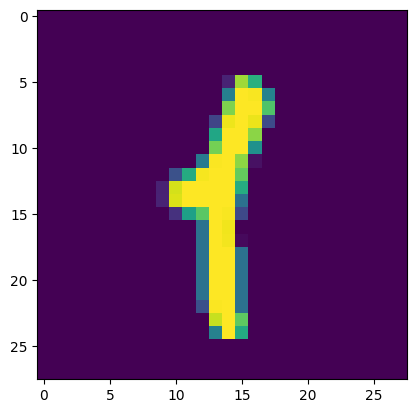

In [ ]:
plt.imshow(X_train[0])

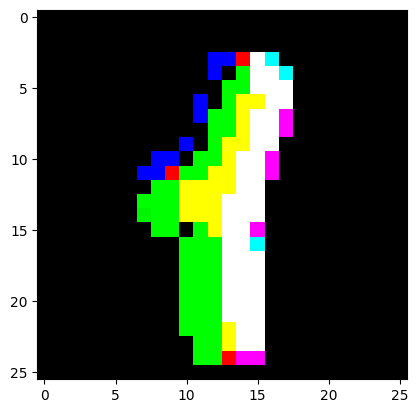

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(k[:,:,:3])

In [ ]:
f = MaxPool(2)

In [ ]:
s = f.forward_prop(k)

[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]]
[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]]
[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]]
[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]]
[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

In [ ]:
import numpy as np

In [ ]:
x = np.random.randn(4,3)
y = np.sum(x,axis = 1,keepdims = True)

In [ ]:
y.shape

(4, 1)

In [ ]:
y

array([[ 0.02802634, -1.21412505]])

In [ ]:
x

array([[-2.04220341, -1.10967153],
       [ 0.70678638, -0.54109805],
       [ 1.36344338,  0.43664453]])